In [1]:
from IPython.display import display

from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

from __future__ import division
import sympy as sym
from sympy import *
x, y, z = symbols("x y z")
k, m, n = symbols("k m n", integer=True)
f, g, h = map(Function, 'fgh')

In [2]:
Rational(3,2)*pi + exp(I*x) / (x**2 + y)

        ⅈ⋅x 
3⋅π    ℯ    
─── + ──────
 2     2    
      x  + y

In [3]:
exp(I*x).subs(x,pi).evalf()

-1.00000000000000

In [4]:
eq = ((x+y)**2 * (x+1))
eq

               2
(x + 1)⋅(x + y) 

In [5]:
expand(eq)

 3      2      2      2            2
x  + 2⋅x ⋅y + x  + x⋅y  + 2⋅x⋅y + y 

In [6]:
a, b = symbols('a b')
Sum(6*n**2 + 2**n, (n, a, b))

  b              
 ___             
 ╲               
  ╲   ⎛ n      2⎞
  ╱   ⎝2  + 6⋅n ⎠
 ╱               
 ‾‾‾             
n = a            

In [7]:
eqn = Eq(Derivative(f(x),x,x) + 9*f(x), 1)
display(eqn)
dsolve(eqn, f(x))

           2          
          d           
9⋅f(x) + ───(f(x)) = 1
           2          
         dx           

f(x) = C₁⋅sin(3⋅x) + C₂⋅cos(3⋅x) + 1/9

## Illustrating a Taylor series

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def plot_taylor_approximations(func, x0=None, orders=(2, 4), xrange=(0,1), yrange=None, npts=200):
    """Plot the Taylor series approximations to a function at various orders.

    Parameters
    ----------
    func : a sympy function
    x0 : float
      Origin of the Taylor series expansion.  If not given, x0=xrange[0].
    orders : list
      List of integers with the orders of Taylor series to show.  Default is (2, 4).
    xrange : 2-tuple or array.
      Either an (xmin, xmax) tuple indicating the x range for the plot (default is (0, 1)),
      or the actual array of values to use.
    yrange : 2-tuple
      (ymin, ymax) tuple indicating the y range for the plot.  If not given,
      the full range of values will be automatically used. 
    npts : int
      Number of points to sample the x range with.  Default is 200.
    """
    if not callable(func):
        raise ValueError('func must be callable')
    if isinstance(xrange, (list, tuple)):
        x = np.linspace(float(xrange[0]), float(xrange[1]), npts)
    else:
        x = xrange
    if x0 is None: x0 = x[0]
    xs = sym.Symbol('x')
    # Make a numpy-callable form of the original function for plotting
    fx = func(xs)
    f = sym.lambdify(xs, fx, modules=['numpy'])
    # We could use latex(fx) instead of str(), but matploblib gets confused
    # with some of the (valid) latex constructs sympy emits.  So we play it safe.
    plt.plot(x, f(x), label=str(fx), lw=2)
    # Build the Taylor approximations, plotting as we go
    apps = {}
    for order in orders:
        app = fx.series(xs, x0, n=order).removeO()
        apps[order] = app
        # Must be careful here: if the approximation is a constant, we can't
        # blindly use lambdify as it won't do the right thing.  In that case, 
        # evaluate the number as a float and fill the y array with that value.
        if isinstance(app, sym.numbers.Number):
            y = np.zeros_like(x)
            y.fill(app.evalf())
        else:
            fa = sym.lambdify(xs, app, modules=['numpy'])
            y = fa(x)
        tex = sym.latex(app).replace('$', '')
        plt.plot(x, y, label=r'$n=%s:\, %s$' % (order, tex) )
        
    # Plot refinements
    if yrange is not None:
        plt.ylim(*yrange)
    plt.grid()
    plt.legend(loc='best').get_frame().set_alpha(0.8)

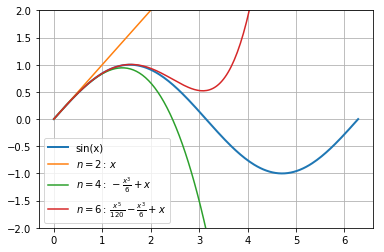

In [10]:
plot_taylor_approximations(sin, 0, [2, 4, 6], (0, 2*pi), (-2,2))

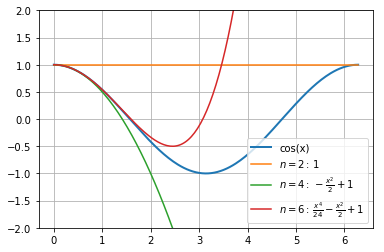

In [11]:
plot_taylor_approximations(cos, 0, [2, 4, 6], (0, 2*pi), (-2,2))

In [24]:
"""
XKCD plot generator
-------------------
Author: Jake Vanderplas

This is a script that will take any matplotlib line diagram, and convert it
to an XKCD-style plot.  It will work for plots with line & text elements,
including axes labels and titles (but not axes tick labels).

The idea for this comes from work by Damon McDougall
  http://www.mail-archive.com/matplotlib-users@lists.sourceforge.net/msg25499.html
"""
import numpy as np
import pylab as pl
from scipy import interpolate, signal
import matplotlib.font_manager as fm


# We need a special font for the code below.  It can be downloaded this way:
import os
import requests as req
if not os.path.exists('Humor-Sans.ttf'):
    fhandle = req.get('http://antiyawn.com/uploads/Humor-Sans-1.0.ttf')
    open('Humor-Sans.ttf', 'wb').write(fhandle.content)

    
def xkcd_line(x, y, xlim=None, ylim=None,
              mag=1.0, f1=30, f2=0.05, f3=15):
    """
    Mimic a hand-drawn line from (x, y) data

    Parameters
    ----------
    x, y : array_like
        arrays to be modified
    xlim, ylim : data range
        the assumed plot range for the modification.  If not specified,
        they will be guessed from the  data
    mag : float
        magnitude of distortions
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    
    Returns
    -------
    x, y : ndarrays
        The modified lines
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    # get limits for rescaling
    if xlim is None:
        xlim = (x.min(), x.max())
    if ylim is None:
        ylim = (y.min(), y.max())

    if xlim[1] == xlim[0]:
        xlim = ylim
        
    if ylim[1] == ylim[0]:
        ylim = xlim

    # scale the data
    x_scaled = (x - xlim[0]) * 1. / (xlim[1] - xlim[0])
    y_scaled = (y - ylim[0]) * 1. / (ylim[1] - ylim[0])

    # compute the total distance along the path
    dx = x_scaled[1:] - x_scaled[:-1]
    dy = y_scaled[1:] - y_scaled[:-1]
    dist_tot = np.sum(np.sqrt(dx * dx + dy * dy))

    # number of interpolated points is proportional to the distance
    Nu = int(200 * dist_tot)
    u = np.arange(-1, Nu + 1) * 1. / (Nu - 1)

    # interpolate curve at sampled points
    k = min(3, len(x) - 1)
    res = interpolate.splprep([x_scaled, y_scaled], s=0, k=k)
    x_int, y_int = interpolate.splev(u, res[0]) 

    # we'll perturb perpendicular to the drawn line
    dx = x_int[2:] - x_int[:-2]
    dy = y_int[2:] - y_int[:-2]
    dist = np.sqrt(dx * dx + dy * dy)

    # create a filtered perturbation
    coeffs = mag * np.random.normal(0, 0.01, len(x_int) - 2)
    b = signal.firwin(f1, f2 * dist_tot, window=('kaiser', f3))
    response = signal.lfilter(b, 1, coeffs)

    x_int[1:-1] += response * dy / dist
    y_int[1:-1] += response * dx / dist

    # un-scale data
    x_int = x_int[1:-1] * (xlim[1] - xlim[0]) + xlim[0]
    y_int = y_int[1:-1] * (ylim[1] - ylim[0]) + ylim[0]
    
    return x_int, y_int


def XKCDify(ax, mag=1.0,
            f1=50, f2=0.01, f3=15,
            bgcolor='w',
            xaxis_loc=None,
            yaxis_loc=None,
            xaxis_arrow='+',
            yaxis_arrow='+',
            ax_extend=0.1,
            expand_axes=False):
    """Make axis look hand-drawn

    This adjusts all lines, text, legends, and axes in the figure to look
    like xkcd plots.  Other plot elements are not modified.
    
    Parameters
    ----------
    ax : Axes instance
        the axes to be modified.
    mag : float
        the magnitude of the distortion
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    xaxis_loc, yaxis_log : float
        The locations to draw the x and y axes.  If not specified, they
        will be drawn from the bottom left of the plot
    xaxis_arrow, yaxis_arrow : str
        where to draw arrows on the x/y axes.  Options are '+', '-', '+-', or ''
    ax_extend : float
        How far (fractionally) to extend the drawn axes beyond the original
        axes limits
    expand_axes : bool
        if True, then expand axes to fill the figure (useful if there is only
        a single axes in the figure)
    """
    # Get axes aspect
    ext = ax.get_window_extent().extents
    aspect = (ext[3] - ext[1]) / (ext[2] - ext[0])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xspan = xlim[1] - xlim[0]
    yspan = ylim[1] - xlim[0]

    xax_lim = (xlim[0] - ax_extend * xspan,
               xlim[1] + ax_extend * xspan)
    yax_lim = (ylim[0] - ax_extend * yspan,
               ylim[1] + ax_extend * yspan)

    if xaxis_loc is None:
        xaxis_loc = ylim[0]

    if yaxis_loc is None:
        yaxis_loc = xlim[0]

    # Draw axes
    xaxis = pl.Line2D([xax_lim[0], xax_lim[1]], [xaxis_loc, xaxis_loc],
                      linestyle='-', color='k')
    yaxis = pl.Line2D([yaxis_loc, yaxis_loc], [yax_lim[0], yax_lim[1]],
                      linestyle='-', color='k')

    # Label axes3, 0.5, 'hello', fontsize=14)
    ax.text(xax_lim[1], xaxis_loc - 0.02 * yspan, ax.get_xlabel(),
            fontsize=14, ha='right', va='top', rotation=12)
    ax.text(yaxis_loc - 0.02 * xspan, yax_lim[1], ax.get_ylabel(),
            fontsize=14, ha='right', va='top', rotation=78)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add title
    ax.text(0.5 * (xax_lim[1] + xax_lim[0]), yax_lim[1],
            ax.get_title(),
            ha='center', va='bottom', fontsize=16)
    ax.set_title('')

    Nlines = len(ax.lines)
    lines = [xaxis, yaxis] + [ax.lines.pop(0) for i in range(Nlines)]

    for line in lines:
        x, y = line.get_data()

        x_int, y_int = xkcd_line(x, y, xlim, ylim,
                                 mag, f1, f2, f3)

        # create foreground and background line
        lw = line.get_linewidth()
        line.set_linewidth(2 * lw)
        line.set_data(x_int, y_int)

        # don't add background line for axes
        if (line is not xaxis) and (line is not yaxis):
            line_bg = pl.Line2D(x_int, y_int, color=bgcolor,
                                linewidth=8 * lw)

            ax.add_line(line_bg)
        ax.add_line(line)

    # Draw arrow-heads at the end of axes lines
    arr1 = 0.03 * np.array([-1, 0, -1])
    arr2 = 0.02 * np.array([-1, 0, 1])

    arr1[::2] += np.random.normal(0, 0.005, 2)
    arr2[::2] += np.random.normal(0, 0.005, 2)

    x, y = xaxis.get_data()
    if '+' in str(xaxis_arrow):
        ax.plot(x[-1] + arr1 * xspan * aspect,
                y[-1] + arr2 * yspan,
                color='k', lw=2)
    if '-' in str(xaxis_arrow):
        ax.plot(x[0] - arr1 * xspan * aspect,
                y[0] - arr2 * yspan,
                color='k', lw=2)

    x, y = yaxis.get_data()
    if '+' in str(yaxis_arrow):
        ax.plot(x[-1] + arr2 * xspan * aspect,
                y[-1] + arr1 * yspan,
                color='k', lw=2)
    if '-' in str(yaxis_arrow):
        ax.plot(x[0] - arr2 * xspan * aspect,
                y[0] - arr1 * yspan,
                color='k', lw=2)

    # Change all the fonts to humor-sans.
    prop = fm.FontProperties(fname='Humor-Sans.ttf', size=16)
    for text in ax.texts:
        text.set_fontproperties(prop)
    
    # modify legend
    leg = ax.get_legend()
    if leg is not None:
        leg.set_frame_on(False)
        
        for child in leg.get_children():
            if isinstance(child, pl.Line2D):
                x, y = child.get_data()
                child.set_data(xkcd_line(x, y, mag=10, f1=100, f2=0.001))
                child.set_linewidth(2 * child.get_linewidth())
            if isinstance(child, pl.Text):
                child.set_fontproperties(prop)
    
    # Set the axis limits
    ax.set_xlim(xax_lim[0] - 0.1 * xspan,
                xax_lim[1] + 0.1 * xspan)
    ax.set_ylim(yax_lim[0] - 0.1 * yspan,
                yax_lim[1] + 0.1 * yspan)

    # adjust the axes
    ax.set_xticks([])
    ax.set_yticks([])      

    if expand_axes:
        ax.figure.set_facecolor(bgcolor)
        ax.set_axis_off()
        ax.set_position([0, 0, 1, 1])
    
    return ax

In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


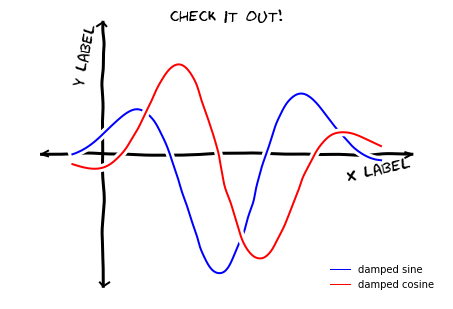

In [28]:
np.random.seed(0)

ax = pylab.axes()

x = np.linspace(0, 10, 100)
ax.plot(x, np.sin(x) * np.exp(-0.1 * (x - 5) ** 2), 'b', lw=1, label='damped sine')
ax.plot(x, -np.cos(x) * np.exp(-0.1 * (x - 5) ** 2), 'r', lw=1, label='damped cosine')

ax.set_title('check it out!')
ax.set_xlabel('x label')
ax.set_ylabel('y label')

ax.legend(loc='lower right')

ax.set_xlim(0, 10)
ax.set_ylim(-1.0, 1.0)

#XKCDify the axes -- this operates in-place
XKCDify(ax, xaxis_loc=0.0, yaxis_loc=1.0,
        xaxis_arrow='+-', yaxis_arrow='+-',
        expand_axes=True)

